### Introduction

Forecasting energy prices in Germany is a challenging task due to the complex interplay of multiple factors, including renewable energy generation, fossil fuel prices, weather conditions, and market regulations. The growing share of renewables in the country’s power grid has introduced additional volatility, making accurate price prediction even more difficult.

Forecasting energy prices in Germany is a challenging task due to the complex interplay of multiple factors, including renewable energy generation, fossil fuel prices, weather conditions, and market regulations. The growing share of renewables in the country’s power grid has introduced additional volatility, making accurate price prediction even more difficult.

As participants in the “BTW 2025 Data Science Challenge,” our goal is to build predictive models that forecast hourly day-ahead energy prices for Germany on February 18, 2025, using historical data. This report begins with an overview of the domain knowledge surrounding Germany’s energy market, followed by a discussion of the data sources used in modeling. Subsequent sections detail the methodology, present modeling results, and offer conclusions.

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [3]:
from src.widgets import get_config_widgets, select_features
from src.dataset import get_datasets, correlation_analysis, unnormalize
from src.feature import create_features, split, create_features_and_split_datasets, get_sets
from src.plot import plot_price_split, plot_energy_mix, plot_final_prediction, plot_feature_importance, plot_predicted
from src.scraping import (
    update_e_mix_data,
    update_e_price_data,
    fetch_historical_weather,
)
from src.prediction import linear_regression, predict_mae, predict_mse, prophet, calculate_error_metrics
from src.final_prediction import fill_up_e_prices, fill_up_energy_mix, fetch_forecast_and_update_csv

In [4]:
update_e_price_data()
update_e_mix_data()
fetch_historical_weather()

CSV found. Last date in file: 2025-02-15. Fetching missing weeks from 2025-02-16...
No new data fetched. Exiting...
No new data added.
Historical data appended to ./data/germany_weather_average.csv.


## 1. Background & Domain Knowledge

### 1.1 Energy Market and Price Dynamics
In Germany, electricity pricing comprises consumer electricity fees and wholesale market prices, with the day-ahead market serving as a key indicator of wholesale price fluctuations. Prices in this market are determined by the “merit order principle,” in which the power plants with the lowest marginal costs are used first to meet demand; ultimately, the price is set by the last plant needed to satisfy demand. Because renewable energy sources generally have low marginal costs, they are dispatched preferentially. However, oversupply, along with grid limitations, can lead to negative prices (Wissenschaftliche Dienste, 2022).

These dynamics underscore the importance of closely examining both supply-side and demand-side factors when forecasting energy prices.

### 1.2 Energy Mix
Germany’s energy mix has evolved significantly, with the share of renewables reaching about 50% of total generation in 2023 (BMWK-Energiewende, 2024). Among these, wind and solar power dominate:

Wind Power: Peaks during winter to spring due to higher wind speeds, typically exerting downward pressure on prices (Clean Energy Wire).
Solar Power: Generates more electricity in summer, reducing prices during daylight hours (Sebastian Kolb, 2020; IMF, 2022).
Despite the rise in renewables, fossil fuels—including hard coal, lignite, and natural gas—still play a critical role. They contribute to price volatility, influenced by fluctuating fuel costs and carbon pricing (Nature, 2024). Understanding both the renewable and fossil-fuel components of the energy mix is therefore crucial for accurate price forecasting.

Hypothesis We hypothesize that there is an inverse relationship between renewable energy production (including solar, wind onshore, wind offshore, and hydro) and next-day energy prices. In other words, as renewable generation increases, the day-ahead market price tends to decrease, largely due to the low marginal costs associated with renewable sources.

<Figure size 1400x1000 with 0 Axes>

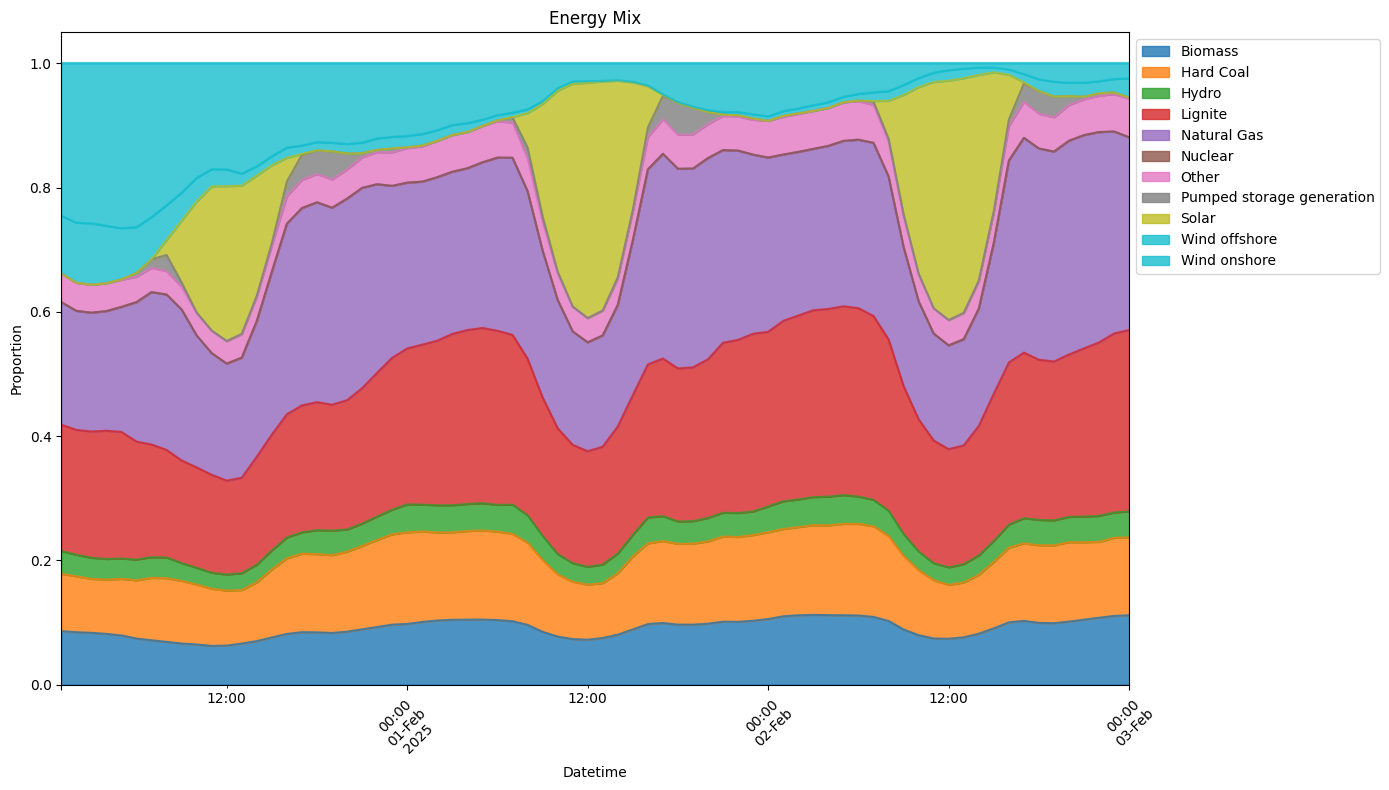

In [5]:
plot_energy_mix()

This plot represents the proportional composition of different energy sources (production in Germany) over the last 72 hours. Each color represents a different energy source contributing to the total energy mix at a particular time.


### 1.3 Weather Impacts
Weather conditions significantly affect energy supply and demand, thereby influencing prices. Key factors include:
- Wind Speeds: Higher winds, especially in northern Germany, boost renewable generation and typically lower prices (Tanaka et al., 2022; Mosquera-Lopez et al., 2024).
- Solar Irradiance: Stronger sunlight in southern regions increases solar power output, putting downward pressure on prices.
- Temperature:
  - Low Temperatures → Increased heating demand → Higher prices
  - High Temperatures → Increased cooling demand → Higher prices
- Precipitation: Affects prices with a delayed impact, possibly by influencing hydropower generation or overall energy demand (Mosquera-Lopez et al., 2024; Springer, 2022; IMF, 2022).

## 2. Data Cleaning

Understanding and preparing the data is a crucial step in any predictive modeling task. In energy price forecasting, data reliability, completeness, and structure play a fundamental role in ensuring the models can capture key trends and dependencies. Given the complexity of the energy market, multiple data sources were used, each contributing essential information. However, some critical datasets were not readily accessible—gas and oil price data were behind a paywall, preventing their inclusion, and electricity demand data was available but consistently missing the last three days, making it unreliable for modeling. Addressing these challenges required careful data cleaning, merging, and feature engineering to build a robust foundation for forecasting models.


## 2.1 Data Sources & Reliabality

Ensuring the reliability of data sources is fundamental in energy price modeling. The datasets used in this analysis are sourced from reputable organizations: Energy prices are sourced from SMARD.de, a platform operated by the German Federal Network Agency, which is recommended for energy price data. Weather data is obtained from Open-Meteo, a provider of historical and forecast weather information that collaborates with national weather services. Data on the energy mix is provided by Agora Energiewende, which offers interactive tools and datasets widely used for analyzing energy mix information. (SMARD, 2025) (Agora Energiewende, 2025)


## 2.2 Data Cleaning and Preparation
To ensure the datasets were ready for analysis, a thorough data cleaning process was carried out. The first step involved handling missing data. One notable challenge was the absence of nuclear energy data after April 15, 2023, due to Germany’s nuclear phase-out. Additionally, any missing values in other datasets were addressed by re-fetching the data from their respective sources to maintain completeness. Ensuring a fully populated dataset was crucial for maintaining consistency across all variables and enabling reliable model training.
Another key aspect was outlier detection. Given the inherent volatility of energy prices, extreme values were carefully examined rather than being removed outright. Instead of discarding outliers indiscriminately, we assessed their impact on the model’s performance. In some cases, extreme values contained meaningful signals about rare market conditions and were retained to ensure the model could adapt to such situations. Each outlier was evaluated in context, preserving those that could provide valuable insights while mitigating the effect of spurious anomalies.
After cleaning the data, we merged different datasets to establish a comprehensive dataset for modeling. Weather data, energy price data, and energy mix data were aligned by date, ensuring that all records were synchronized correctly. This step was crucial for creating a structured dataset that allowed for meaningful feature extraction and analysis in the subsequent modeling phase.


## 2.3 Correlation Analysis
We explored the relationship between different factors (weather variables, energy mix) and energy prices. Initial findings revealed an inverse correlation between renewable energy generation (solar, wind onshore, wind offshore, hydro) and energy prices, with an observed moderate negative correlation coefficient of -0.312. (pic a)



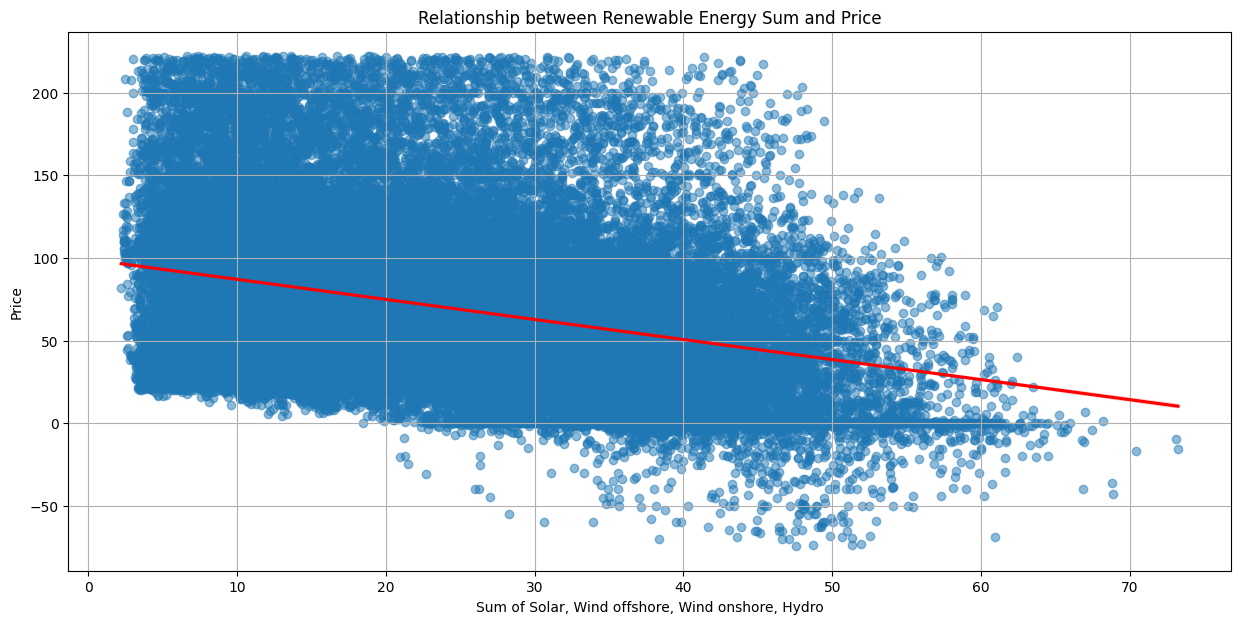

Test Score:  -0.30497358159480326
One Tailed P-Value:  1.1102230246251565e-16


In [6]:
correlation_analysis()

We explored the relationship between different factors (weather variables, energy mix) and energy prices. Initial findings revealed an inverse correlation between renewable energy generation (solar, wind onshore, wind offshore, hydro) and energy prices, with an observed moderate negative correlation coefficient of -0.312. (pic a)

## Data loading

In handling missing values, we removed all rows containing missing entries in either the energy price or energy mix columns. The weather dataset was complete, so no additional steps were necessary for that. Since nuclear energy production reporting ceased in 2024, we set any missing nuclear values to 0.0 from that point onward.

For outlier removal, we employed two different approaches. When conducting statistical tests, we used the Interquartile Range (IQR) method to identify and exclude extreme values. For model training, outliers were removed manually using a slider in the “Configuration” interface, allowing fine-grained control over which data points to retain.

In [7]:
merged_df, e_price_df = get_datasets()

## Configuration


In [8]:
price_interval, eval_size, normalize =  get_config_widgets()

IntRangeSlider(value=(-20, 400), continuous_update=False, description='Energy Price Interval', max=900, min=-5…

FloatSlider(value=0.05, description='Evaluation Set Size', max=0.2, step=0.01)

Checkbox(value=False, description='Normalize')

## 3. Features
Selecting relevant features is crucial for building an effective predictive model. Given the diverse range of available data—including time-based attributes, moving averages, energy generation sources, and weather variables—our selection process focused on maximizing predictive power while avoiding redundancy. Since energy prices exhibit strong temporal dependencies, time-based features were incorporated to capture seasonal and weekly patterns. The importance of these features has been previously discussed in the context of price dynamics (see Section 1.1.1). Additionally, moving averages played a key role in smoothing short-term fluctuations and enhancing model stability, as outlined in Section 3.1. Beyond time-related attributes, energy mix variables were selected based on their direct impact on electricity prices. Renewable energy sources, particularly solar and hydro, were included due to their well-documented influence on price formation. Weather variables, such as temperature, precipitation, and direct radiation, were chosen for their role in both energy demand and renewable generation variability. These relationships have been analyzed in Section 1.1.3, reinforcing their relevance in predictive modeling. By carefully curating our feature set, we ensured that the model balances complexity and interpretability while capturing the fundamental drivers of energy price fluctuations. This selection process aimed to improve forecasting accuracy without introducing unnecessary computational overhead.


## 3.1 Moving Averages and Their Role in Forecasting
Moving averages are essential for smoothing out short-term fluctuations in time-series data and revealing underlying trends. By averaging values over a defined window, moving averages reduce noise and enhance the visibility of long-term patterns.
For linear regression-based models, moving averages provide several benefits:
- *Noise Reduction*: Energy price data can be volatile due to external shocks, market fluctuations, and unexpected demand surges. Moving averages help smooth these fluctuations, enabling the model to focus on broader trends rather than reacting to random variations.
- *Feature Engineering*: Moving averages can serve as additional explanatory variables in regression models, capturing smoothed past behavior that informs future predictions.
Seasonality Handling: By choosing appropriate window sizes (e.g., 24-hour, 7-day, or 30-day moving averages), it is possible to better capture daily, weekly, or monthly cycles in energy prices.
- *Enhanced Interpretability*: Linear models often struggle with high-frequency variations. Incorporating moving averages helps them generalize better by reducing the emphasis on short-term noise.
Given the time-series nature of energy prices, we applied moving averages with various window sizes (e.g., hourly and daily) to analyze how different trends affect price fluctuations. This was particularly useful in identifying seasonal effects and ensuring that models could make robust predictions without overfitting to short-term anomalies.

In [9]:
get_features, default_features = select_features()

GridBox(children=(Checkbox(value=True, description='hour'), Checkbox(value=True, description='dayofyear'), Che…

Output()

Button(description='Confirm Selection', style=ButtonStyle())

In [10]:
# RERUN WHEN TICKING the NORMALIZED BOX
min_price, max_price = price_interval.value

(
    train,
    eval,
    test,
    benchmark,
    SPLIT_DATE_EVAL,
    SPLIT_DATE_TEST,
    SPLIT_DATE_BENCHMARK,
    train_interval,
    eval_interval,
    test_interval,
    benchmark_interval,
    SPLIT_DATE_EVAL_INTERVAL,
    SPLIT_DATE_TEST_INTERVAL,
    SPLIT_DATE_BENCHMARK,
    scalar,
    FEATURES
) = create_features_and_split_datasets(
    merged_df.copy(),
    default_features,
    get_features(),
    min_price,
    max_price,
    e_price_df.copy(),
    normalize.value,
    eval_size.value,
)


(   X_train, y_train, X_val, y_val, X_test, y_test,
    X_train_interval,
    y_train_interval,
    X_val_interval,
    y_val_interval,
    X_test_interval,
    y_test_interval,
) = get_sets(train, eval, test, train_interval, eval_interval, test_interval, FEATURES)

In [11]:
# plot_price_split(train, eval, test, benchmark, SPLIT_DATE_EVAL, SPLIT_DATE_TEST, SPLIT_DATE_BENCHMARK, "outliers includuded")
# plot_price_split(train_interval, eval_interval, test_interval, benchmark_interval, SPLIT_DATE_EVAL_INTERVAL, SPLIT_DATE_TEST_INTERVAL, SPLIT_DATE_BENCHMARK, "ex outliers")

## 3.2 Evaluation Criteria

To assess model performance, we considered the following:
1. Error Objectiv Functions
- RMSE (Root Mean Squared Error): Measures overall prediction error, with a stronger penalty for large deviations.
- MAE (Mean Absolute Error): Reflects the average magnitude of errors without emphasizing outliers as strongly as RMSE.
- MSE (Mean Squared Error): Calculates the average of the squared differences between actual and predicted values, providing a general measure of error while penalizing larger errors more than MAE.
- MAPE (Mean Absolute Percentage Error): Expresses the average absolute error as a percentage of actual values, making it useful for comparing errors across different scales or datasets.
2. Handling of Seasonality and Outliers
- The ability to capture daily, weekly, and yearly seasonality effectively.
- Robustness to price spikes and outliers due to external factors like demand surges or market shocks.
3. Ease of Interpretation
- Linear models like Regression provide direct insight into feature importance.
- Prophet allows for intuitive trend and seasonality decomposition.
- XGBoost requires careful feature engineering to extract meaningful insights.
4. Faster Iteration and Scalability
- Training time and computational efficiency.
- Ability to adapt and fine-tune hyperparameters efficiently.



## 4 Model Selection and Training

Selecting an appropriate modeling approach is a critical step in building a reliable forecasting system. Given the complexity of energy price dynamics, the choice of models must balance accuracy, interpretability, and computational efficiency. A well-defined modeling strategy typically begins with a simple yet effective baseline model before progressing to more advanced techniques. This ensures that improvements gained from sophisticated models are measured against a meaningful reference point. In this section, we outline the reasoning behind our model selection process, beginning with a baseline model and advancing to more specialized forecasting methods.

## 4.1 Choosing a Baseline Model
For our initial baseline model, we selected Linear Regression due to its simplicity, interpretability, and computational efficiency. Linear Regression provides a straightforward approach to capturing linear relationships in the data, making it an excellent reference point for evaluating more complex models. However, it struggles with capturing non-linear dependencies and seasonality, which are crucial in energy price forecasting.
We opted against using neural networks due to several reasons:
- **Computational Cost**: Training deep learning models requires significant computational resources, which were not justified given the available dataset size and forecasting horizon.
- **Interpretability**: Neural networks act as black-box models, making it difficult to extract insights about seasonal trends, price spikes, or external influencing factors.
- **Data Requirements**: Deep learning models typically require large amounts of high-quality data to generalize well. Given our dataset’s structure, traditional time-series models were more suitable.
## 4.2 XGBoost
XGBoost (Extreme Gradient Boosting) is a machine learning algorithm based on decision trees, well-suited for structured datasets like ours. It excels at capturing non-linear relationships, allowing it to model complex interactions between features and energy prices, which Linear Regression cannot do. XGBoost also provides built-in feature importance metrics, helping identify key factors like weather, energy mix, and demand fluctuations. It handles missing data and outliers better than traditional models, making it a robust choice for real-world forecasting. Computationally efficient compared to deep learning models, XGBoost performs well for our dataset, although it requires feature engineering and hyperparameter tuning. Its ability to capture short-term fluctuations and complex feature interactions can enhance forecasting accuracy.

Gradient Boosting is an ensemble learning technique that builds a model by iteratively improving the predictions of weak learners (typically decision trees). Each new model focuses on the errors of the previous one, reducing them in a sequential manner. This allows Gradient Boosting to handle complex patterns and interactions in the data, making it effective for tasks like forecasting energy prices.
## 4.3 Prophet
Prophet, developed by Facebook, is designed for time-series forecasting, particularly in capturing seasonality, trends, and holiday effects. It automatically detects daily, weekly, and yearly seasonality, which is helpful for energy price forecasting, where such patterns dominate. Prophet is robust to missing data and outliers, improving forecast reliability. Unlike traditional models, Prophet allows trend changes over time, making it ideal for dynamic markets. It also provides clear decompositions of trend, seasonality, and holiday effects, offering interpretability that aids understanding of energy price drivers. Prophet’s combination of seasonality detection, trend flexibility, and ease of use makes it a powerful tool for forecasting energy prices.


### Linear Regression

In [12]:
# lr_prediction = linear_regression(X_train, y_train, X_test, y_test, scalar)

### XGBoost

In [13]:
# xgb_y_prediction_mse, xgb_mse = predict_mse(
#     X_train_interval, y_train_interval, X_val_interval, y_val_interval, X_test_interval, scalar
# )
# xgb_y_prediction_mae, xgb_mae = predict_mae(
#     X_train_interval, y_train_interval, X_val_interval, y_val_interval, X_test_interval, scalar
# )

# plot_feature_importance((xgb_mse, xgb_mae))

### Prophet

In [14]:
# prophet_prediction = prophet(FEATURES, X_train, y_train, X_test, scalar)

In [15]:
# if scalar:
#     y_test = unnormalize(y_test, scalar)

## Results

### Errors

In [16]:
# calculate_error_metrics(
#     y_test, y_test_interval, [lr_prediction, prophet_prediction, xgb_y_prediction_mse, xgb_y_prediction_mae]
# )

### Plots

In [17]:
# predictions = [
#     (prophet_prediction, "Prophet", "MSE"),
#     (xgb_y_prediction_mse, "XGBoost", "MSE"),
#     (xgb_y_prediction_mae, "XGBoost", "MAE"),
#     (lr_prediction, "Linear Regression", "MSE"),
# ]

# plot_predicted(y_test, predictions)

## Benchmarking

The Benchmark Test in this model evaluates the performance of different forecasting algorithms (Prophet, Linear Regression, and XGBoost) to predict the energy price for February 18th. To determine which model performs best, we simulate predicting the price for this specific day across a whole month, testing the models' abilities to accurately forecast the price. The Data Preparation step involves merging and splitting the dataset into training, evaluation, and test sets. The training data includes all available historical data up to a specific point, while the evaluation and test sets are used to assess model performance on unseen data. The benchmark dataset is used to simulate forecasting and serves as the reference to compare the models’ predictions. The core of the test is the Rolling Forecast Loop, which processes the dataset in 24-hour intervals. Starting 24 hours before the day to predict, the loop moves in steps of 24 hours, predicting the price for the day to predict each time. The models are retrained on all available data up to the current point, extending the dataset with each iteration. If there is any missing data, the forecast for that window is skipped. In each iteration, the three models are trained and used to predict the price for one day. After simulating predictions for all relevant windows, the results are aggregated. The average RMSE is computed for each model, and the one with the lowest RMSE will be selected as the best model for predicting the price on February 18th. The Benchmark Test Setup helps simulate real-world forecasting conditions by repeatedly training and testing the models over a period of time. By comparing the RMSE values, we can objectively assess which model provides the most accurate prediction for the specific day we are targeting — February 18th.



In [18]:
# Constants and Configurations
# =============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from src.benchmark import extend_by_predictions_and_samples
from src.plot import plot_benchmark_predictions
from src.prediction import init_prophet_model

WINDOW_SIZE = 24  # Forecasting window of 24 hours

# Columns to use from the datasets
COLUMNS = [
    "Price",
    "Hydro",
    "Pumped storage generation",
    "Solar",
    "Wind offshore",
    "Wind onshore",
    "temperature_2m",
    "precipitation",
    "wind_speed_100m",
    "direct_radiation",
]

# Final features used for model training and forecasting
FINAL_FEATURES = [
    "hour",
    "dayofyear",
    "dayofweek",
    "Hydro",
    "Pumped storage generation",
    "Solar",
    "Wind offshore",
    "Wind onshore",
    "temperature_2m",
    "precipitation",
    "wind_speed_100m",
    "direct_radiation",
]

FINAL_FEATURES_XGB = [
    "Pumped storage generation",
    "Solar",
    "Wind offshore",
    "temperature_2m",
    "wind_speed_100m",
    "hour",
    "dayofweek",
    "dayofyear",
    "ma_1_days",
    "ma_1_days_pumped_storage_generation",
    "ma_2_days",
    "ma_2_days_pumped_storage_generation",
    "ma_3_days",
    "ma_4_days_pumped_storage_generation",
    "ma_5_days_pumped_storage_generation",
    "ma_6_days",
    "ma_7_days",
    "ma_8_days_pumped_storage_generation",
    "ma_9_days_pumped_storage_generation",
    "ma_10_days",
    "ma_11_days",
    "ma_12_days_pumped_storage_generation",
    "ma_13_days",
    "ma_14_days_pumped_storage_generation",
]

FINAL_FEATURES_PROPHET = [
    "Hydro",
    "Solar",
    "Wind offshore",
    "Wind onshore",
    "temperature_2m",
    "precipitation",
    "direct_radiation",
    "hour",
    "dayofweek",
    "ma_1_days",
    "ma_1_days_pumped_storage_generation",
    "ma_4_days_pumped_storage_generation",
    "ma_5_days",
    "ma_5_days_pumped_storage_generation",
    "ma_6_days",
    "ma_8_days",
    "ma_8_days_pumped_storage_generation",
    "ma_10_days",
    "ma_11_days",
    "ma_12_days",
    "ma_12_days_pumped_storage_generation",
    "ma_13_days",
    "ma_14_days",
    "ma_14_days_pumped_storage_generation"
]

XGB_hyp_params = {
    "base_score": 0.5789230150549212,
    "learning_rate": 0.006032821602006745,
    "max_depth": 90,
    "n_estimators": 888,
    "gamma": 4.026209209533667,
    "min_child_weight": 4,
    "subsample": 0.7320835295857154,
    "colsample_bylevel": 0.8758263640368676,
    "max_delta_step": 0,
    "early_stopping_rounds": 80,
}

XGB_hyp_params_old = {
    "base_score": 0.380924762889507,
    "early_stopping_rounds": 215,
    "max_depth": 80,
    "learning_rate": 0.06,
    "n_estimators": 150,
    "gamma": 0.9,
    "min_child_weight": 6,
    "subsample": 0.5719023844219375,
    "colsample_bytree": 0.8815691043681952,
}

# =========================================================================
# 1. Data Preparation
# =========================================================================

# Get and split datasets
merged_df, _ = get_datasets()
train, eval, test, benchmark, _, _, _ = split(merged_df)

# Combine all available training data
training_set = pd.concat([train, eval, test])[COLUMNS]
# Benchmark dataset for rolling forecast
benchmarking_set = benchmark[COLUMNS]

# Lists to hold evaluation metrics for each window
rmses = []  # Will store tuples of (prophet_rmse, lr_rmse, xgb_rmse)

# =========================================================================
# 2. Rolling Forecast Loop
# =========================================================================

# We start from 24 hours in, to skip an initial period if needed
for window_start in tqdm(range(24, len(benchmarking_set) - WINDOW_SIZE, WINDOW_SIZE)):
    # Current forecast window for the next 24 hours
    y_actual = benchmarking_set.iloc[window_start : window_start + WINDOW_SIZE]["Price"]
    print("\nDate to predict: ", y_actual.index[0])

    # Extend the dataset with available data prior to the forecast window
    dataset_extended = pd.concat((training_set, benchmarking_set.iloc[:window_start]))
    next_day = dataset_extended.index[-1] + pd.DateOffset(hours=1)

    # If there's a gap in data, skip the forecast for this window
    if next_day != y_actual.index[0]:
        print(
            f"\nSkipping prediction for {next_day} due to missing entries.\n"
            "--------------------------------------------------------------\n"
        )
        continue

    # Extend the dataset by predicted values and samples if necessary
    dataset_extended_ps = extend_by_predictions_and_samples(
        dataset_extended, dataset_extended.index[-1]
    )

    # Create features required for model training and for predictions
    dataset_extended_features = create_features(dataset_extended_ps)

    # Split for training (all but last 24 hours) and prediction (the next 24 hours)
    VALIDATION_SET_SIZE = 24 * 14
    X_train_df = dataset_extended_features.iloc[:-WINDOW_SIZE - VALIDATION_SET_SIZE]
    X_eval_df = dataset_extended_features.iloc[-WINDOW_SIZE - VALIDATION_SET_SIZE : -WINDOW_SIZE]
    X_predict_df = dataset_extended_features.reindex(y_actual.index)

    # Prepare Prophet-compatible dataframe
    # Prophet requires 'ds' (date/time) and 'y' (target) columns.
    X_train_prophet = (
        X_train_df[["Price"] + FINAL_FEATURES_PROPHET]
        .rename(columns={"Price": "y"})
        .reset_index()
        .rename(columns={"index": "ds"})
        .dropna()
    )
    prophet_X_predict = X_predict_df[FINAL_FEATURES_PROPHET].reset_index().rename(columns={"index": "ds"})

    # =====================================================================
    # 2.1. Prophet Model
    # =====================================================================
    # If using a custom initialization, the function might set up seasonality, holidays, etc.
    prophet_model = init_prophet_model(FINAL_FEATURES_PROPHET)
    prophet_model.fit(X_train_prophet)

    # Generate a forecast. Adding constant to Prophet's forecast can offset a systematic bias.
    prophet_forecast = prophet_model.predict(prophet_X_predict)["yhat"] + 13

    # =====================================================================
    # 2.2. Linear Regression
    # =====================================================================
    lr = LinearRegression()
    lr.fit(X_train_df[FINAL_FEATURES_XGB], X_train_df["Price"])
    lr_forecast = lr.predict(X_predict_df[FINAL_FEATURES_XGB])

    # =====================================================================
    # 2.3. XGBoost
    # =====================================================================
    xgb_model = XGBRegressor(**XGB_hyp_params, n_jobs=8)
    xgb_model.fit(X_train_df[FINAL_FEATURES_XGB], X_train_df["Price"], eval_set=[(X_eval_df[FINAL_FEATURES_XGB], X_eval_df["Price"])])
    xgb_forecast = xgb_model.predict(X_predict_df[FINAL_FEATURES_XGB])

    # Display date ranges used (for debugging/traceability)
    # print_date_ranges(
    #     X_train_prophet,
    #     X_train_df[FINAL_FEATURES],
    #     X_train_df["Price"],
    #     y_actual,
    #     prophet_X_predict,
    #     X_predict_df,
    # )

    # =====================================================================
    # 2.4. Plot Predictions
    # =====================================================================
    plot_benchmark_predictions(
        y_actual,
        X_predict_df,
        prophet_X_predict,
        prophet_forecast,
        lr_prediction=lr_forecast,
        xgb_prediction=xgb_forecast,
    )

    # =====================================================================
    # 2.5. Compute Metrics
    # =====================================================================
    prophet_rmse = np.sqrt(mean_squared_error(y_actual, prophet_forecast))
    lr_rmse = np.sqrt(mean_squared_error(y_actual, lr_forecast))
    xgb_rmse = np.sqrt(mean_squared_error(y_actual, xgb_forecast))

    # Print metrics for this window
    print(f"Prophet RMSE: {prophet_rmse}")
    print(f"Linear Regression RMSE: {lr_rmse}")
    print(f"XGBoost RMSE: {xgb_rmse}")
    print("--------------------------------------------------------")

    # Accumulate metrics for later averaging
    rmses.append((prophet_rmse, lr_rmse, xgb_rmse))

# =========================================================================
# 3. Compute Average Metrics and Print Results
# =========================================================================

if rmses:
    avg_rmse = tuple(sum(x) / len(rmses) for x in zip(*rmses))
    print(
        f"Linear Regression: {avg_rmse[0]}, XGBoost: {avg_rmse[1]}"
    )
    print(
        f"\nAverage RMSEs - Prophet: {avg_rmse[0]}, "
        f"Linear Regression: {avg_rmse[1]}, XGBoost: {avg_rmse[2]}"
    )
else:
    print("No forecasts were computed. Check data availability and index alignment.")

  0%|          | 0/30 [00:00<?, ?it/s]


Date to predict:  2025-01-14 00:00:00


18:27:49 - cmdstanpy - INFO - Chain [1] start processing
  0%|          | 0/30 [00:28<?, ?it/s]


KeyboardInterrupt: 

## 5. Results
We began our analysis by testing three different models - Linear Regression, XGBoost, and Prophet - to determine the most effective approach for forecasting energy prices. To establish a baseline, we initially evaluated these models without any additional features, relying solely on historical price data. Following this initial assessment, we introduced external features to enhance the models' predictive capabilities. We first tested the models using only energy mix features. Then we tested only weather features. While both feature sets individually improved model accuracy, the best results were achieved when combining energy mix and weather features. To further refine the models, we applied an AutoML process for feature selection. This step automatically identified the most relevant variables while eliminating those that contributed little to predictive accuracy. The inclusion of these optimized features improved the predictive performance across all three models. After finalizing the feature set, we conducted a second AutoML process to optimize hyperparameters for XGBoost and Prophet. With the optimized models in place, we compared their final performance based on MAE, MSE, RMSE, and MAPE. Linear Regression performed the worst, showing the highest RMSE and MAE. XGBoost performed better than expected and ultimately outperformed Prophet in our specific scenario. While Prophet achieved the lowest RMSE and MAE, its accuracy depended on the availability of the energy mix forecast, which is published too late for the challenge. Without access to this crucial feature, XGBoost delivered better results than Prophet. Although Prophet’s ability to model seasonality, trends, and external variables makes it the most accurate option in ideal conditions, its reliance on unavailable data made it impractical for our forecasting needs. Given these constraints, we selected XGBoost as our final model to predict the energy price for February 18th.




## Final Prediction 18.02.2025 00:00:00 - 19.02.2025 00:00:00

C:\Users\elias\PycharmProjects\TestJetzte\hand_in\src\final_prediction.py:124: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  new_index = pd.date_range(


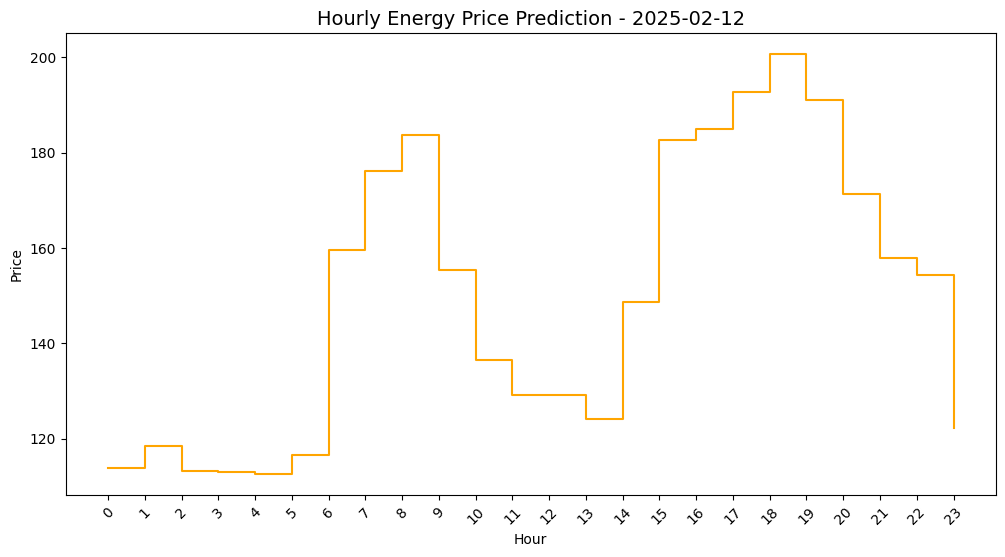

In [ ]:
start_date = '2025-02-12 00:00:00'
end_date = '2025-02-12 23:00:00'

# update_e_price_data()
# update_e_mix_data()
# fetch_historical_weather()

fill_up_e_prices(end_date)
fill_up_energy_mix(end_date)
fetch_forecast_and_update_csv(end_date)

# Columns to use from the datasets
COLUMNS = [
    "Price",
    "Hydro",
    "Pumped storage generation",
    "Solar",
    "Wind offshore", "Wind onshore",
    "temperature_2m", "precipitation",
    "wind_speed_100m", "direct_radiation"
]

# Final features used for model training and forecasting
FINAL_FEATURES = [
    "Hydro",
    "Solar",
    "Wind offshore",
    "Wind onshore",
    "temperature_2m",
    "precipitation",
    "direct_radiation",
    "hour",
    "dayofweek",
    "ma_1_days",
    "ma_1_days_pumped_storage_generation",
    "ma_4_days_pumped_storage_generation",
    "ma_5_days",
    "ma_5_days_pumped_storage_generation",
    "ma_6_days",
    "ma_8_days",
    "ma_8_days_pumped_storage_generation",
    "ma_10_days",
    "ma_11_days",
    "ma_12_days",
    "ma_12_days_pumped_storage_generation",
    "ma_13_days",
    "ma_14_days",
    "ma_14_days_pumped_storage_generation"
]

# =============================================================================
# Data Preparation
# =============================================================================
merged_df, _ = get_datasets(predict=True)

# Extend the training data with any benchmarking data available before the current window.
feature_df = create_features(merged_df[COLUMNS])

# Split the data into training and benchmarking sets
training_set = feature_df.loc[:start_date]
prediction_set = feature_df.loc[start_date:end_date]

# Prepare the training data for XGBoost.
X_train = training_set[FINAL_FEATURES]
y_train = training_set["Price"]
X_predict = prediction_set[FINAL_FEATURES]

# ------------------------- XGBoost Model -------------------------
# Initialize the XGBoost model.
xgb_model = XGBRegressor()

# Fit the XGBoost model and make predictions.
xgb_model.fit(X_train, y_train)
xgb_forecast = xgb_model.predict(X_predict)

# Prepare the forecast dataframe.
xgb_forecast_df = pd.DataFrame({
    "ds": prediction_set.index,
    "yhat": xgb_forecast
})
xgb_forecast_df.set_index("ds", inplace=True)
xgb_forecast_df.to_csv("predictions.csv", index=True, mode="w")

plot_final_prediction(xgb_forecast_df, start_date)

### 6. Conclusion

Our analysis revealed several key insights about energy price forecasting. One of the most surprising findings was that moving averages did not improve model performance due to the lack of accurate future data. While moving averages are commonly used to smooth short-term fluctuations, they rely on future observations, which are unavailable in a true forecasting scenario. This limitation made them ineffective for our models.

Another significant result was the correlation between renewable energy generation and energy prices. As the share of renewables increased, prices tended to decrease, highlighting the impact of renewable energy sources on market dynamics. Additionally, we found that incorporating weather and energy mix features significantly improved forecasting accuracy, as reflected in the reduction of RMSE across all models. These external factors provided crucial information about supply and demand fluctuations, making them essential for accurate price predictions.

We also discovered that some months are easier to predict than others. For example, December was easier to forecast than January. Similarly, certain time periods, such as nighttime, were more predictable than daytime, likely due to more stable demand patterns. Both XGBoost and Prophet performed well in capturing trends and spikes, but they consistently exhibited slight shifts, particularly around sharp price spikes.

Among the models tested, XGBoost emerged as the best performer, achieving the lowest average RMSE in our specific scenario. While Prophet demonstrated superior accuracy in ideal conditions due to its ability to model seasonality, trends, and external regressors, its performance relied on the availability of the energy mix forecast, which is published too late for the challenge. Without this crucial feature, XGBoost outperformed Prophet, making it the more reliable choice for our forecasting task. Given these constraints, we selected XGBoost as our final model.

For further improvements, several steps could be taken. One important enhancement would be to incorporate oil and gas prices, as these external economic factors have a direct influence on energy markets. Adding such financial indicators could provide a more comprehensive view of price fluctuations. Additionally, increasing the amount of historical data available for training could further improve model performance by capturing long-term trends and rare market conditions.

Another key improvement would be further optimization through AutoML. We encountered challenges in efficiently utilizing all available CPU cores, particularly because Prophet is single-threaded, making it computationally expensive. Ensuring proper multi-threading capabilities for Prophet could significantly reduce training times. AutoML, while beneficial for feature selection and hyperparameter tuning, had a very high runtime, which limited its full potential. Addressing these computational constraints could lead to even better model performance and efficiency.

By expanding the dataset, integrating more relevant features, optimizing computational resources, and leveraging AutoML more effectively, the accuracy and robustness of our forecasts could be further enhanced, making the predictions even more reliable.